In [ ]:
# ==========================================================
# TAHAP 1: SETUP, IMPOR PUSTAKA, DAN MUAT DATA
# ==========================================================
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from google.colab import drive
drive.mount('/content/gdrive')

FILE_NAME = "/content/gdrive/MyDrive/Data Mining/MyTelkomsel/Tiktok.xlsx"

print("Setup Pustaka Selesai.")

# Muat dataset
try:
    df = pd.read_excel(FILE_NAME)

    # Ambil hanya 2 kolom pertama
    df = df.iloc[:, :2]  # Kolom 0 dan 1 saja
    df.columns = ['id', 'ulasan']
    df = df.dropna(subset=['ulasan'])
    print(f"\n[HASIL 1.1] Data berhasil dimuat. Total baris: {len(df)}")
    print("\n--- 5 Baris Pertama Data Awal ---")
    print(df.head(1024))
except FileNotFoundError:
    print(f"\n[ERROR] File '{FILE_NAME}' tidak ditemukan. Pastikan Anda sudah mengunggahnya ke sesi Colab.")

Mounted at /content/gdrive
Setup Pustaka Selesai.

[HASIL 1.1] Data berhasil dimuat. Total baris: 99996

--- 5 Baris Pertama Data Awal ---
                   id                                             ulasan
0     Pengguna Google                              bagus aku suka banget
1     Pengguna Google                                             Mantap
2     Pengguna Google  Bisa mendownload tapi tidak bisa masuk,dan jik...
3     Pengguna Google  Aku suka tiktok tetapi tidak bisa membuat jeda...
4     Pengguna Google  Tiktok sekarang udah jelek kebanyakan di updat...
...               ...                                                ...
1019  Pengguna Google                                              Bagus
1020  Pengguna Google  pdhal HP saya ram8 msih aja ngelaq dia gimana ...
1021  Pengguna Google                                            Tik tok
1022  Pengguna Google  kocak makin lama makin banyak bug , tiba " ken...
1023  Pengguna Google  Aplikasi apaan ini udah penyimpanan

In [ ]:
# ==========================================================
# TAHAP 2: PRA-PEMROSESAN DAN NORMALISASI TEKS
# ==========================================================
print("\n[HASIL 2.1] Memulai Pra-pemrosesan Teks...")

# Kamus Normalisasi Slang (Contoh Sederhana)
slang_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'gmn': 'bagaimana', 'bgus': 'bagus',
    'brg': 'barang', 'dgn': 'dengan', 'sdh': 'sudah', 'yg': 'yang',
    'udh': 'sudah', 'tpi': 'tapi', 'sy': 'saya', 'krg': 'kurang',
    'pky': 'pakai', 'mksh': 'terima kasih', 'thx': 'terima kasih',
    'tp': 'tapi', 'utk': 'untuk', 'aja': 'saja', 'bgt': 'banget',
    'ok': 'oke', 'mantab': 'mantap', 'bwt': 'buat', 'cepet': 'cepat',
    'respon': 'respons', 'tdk': 'tidak', 'jg': 'juga', 'sampe': 'sampai'
}

def normalize_and_clean(text):
    text = str(text).lower()

    # 1. Hapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # 2. Tokenisasi dan Normalisasi Slang
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]

    # 3. Gabungkan kembali dan hapus spasi berlebih
    text = " ".join(normalized_words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan fungsi preprocessing
df['cleaned_text'] = df['ulasan'].apply(normalize_and_clean)

# Tampilkan perbandingan
print("\n[HASIL 2.2] Contoh Perbandingan Teks Setelah Normalisasi:")
contoh_index = 47138
if contoh_index < len(df):
    print(f"Asli (ID {contoh_index}): {df['ulasan'].iloc[contoh_index]}")
    print(f"Bersih (ID {contoh_index}): {df['cleaned_text'].iloc[contoh_index]}")
else:
    print("Contoh indeks di luar batas data.")


[HASIL 2.1] Memulai Pra-pemrosesan Teks...

[HASIL 2.2] Contoh Perbandingan Teks Setelah Normalisasi:
Asli (ID 47138): sangat baik
Bersih (ID 47138): sangat baik



[HASIL 3.1] Memulai Pelabelan Sentimen Manual untuk TF-IDF...

[HASIL 3.2] Distribusi Sentimen (Labels untuk Training):
target_y
Negatif    26826
Netral     38702
Positif    34468
Name: count, dtype: int64
----------------------------------------
Persentase Negatif: 26.83%
Persentase Netral: 38.70%
Persentase Positif: 34.47%


/tmp/ipython-input-3609394129.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=bar_colors)


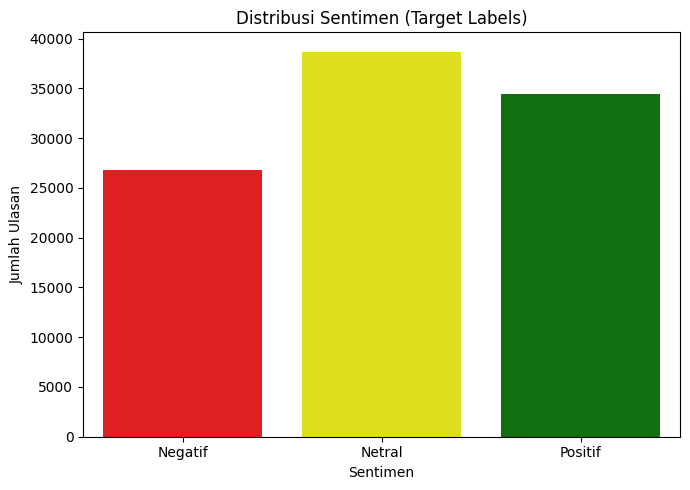


[INFO] Label sentimen siap untuk TF-IDF training!


In [ ]:
# ==========================================================
# TAHAP 3: PELABELAN SENTIMEN MANUAL (UNTUK SUPERVISED LEARNING)
# ==========================================================
print("\n[HASIL 3.1] Memulai Pelabelan Sentimen Manual untuk TF-IDF...")

# Lexicon Lengkap untuk Pelabelan Awal
positive_words = set([
    'mudah', 'simple', 'praktis', 'intuitif', 'sat set', 'tidak ribet', 'gampang', 'efisien', 'cepat', 'instan',
    'ringan', 'lancar', 'lengkap', 'berguna', 'bermanfaat', 'terbaik', 'baik', 'bagus', 'mantap', 'sesuai',
    'oke', 'puas', 'rekomendasi', 'murah', 'promo', 'hemat', 'terjangkau', 'bonus', 'diskon', 'eksklusif',
    'keren', 'modern', 'nyaman', 'menarik', 'sukses', 'terima kasih', 'membantu', 'inovatif', 'the best',
    'nyaman dipandang', 'good', 'fyp', 'viral', 'menghibur', 'kreatif', 'edukatif', 'seru', 'nagih',
    'estetik', 'cuan', 'gratis ongkir', 'amanah', 'responsif', 'inspiratif', 'berbakat', 'top', 'gacor',
    'lucu', 'informatif', 'asli', 'original', 'sempurna', 'excellent', 'memuaskan', 'recommended'
])

negative_words = set([
    'lemot', 'lambat', 'lag', 'berat', 'force close', 'keluar sendiri', 'loading terus', 'muter-muter', 'eror',
    'bug', 'gagal', 'tidak bisa login', 'tidak bisa dibuka', 'sulit masuk', 'gangguan', 'koneksi buruk', 'mahal',
    'boros', 'mencekik', 'tidak adil', 'harga naik', 'kuota cepat habis', 'rugi', 'ribet', 'membingungkan',
    'sulit', 'cacat', 'kecewa', 'tidak sesuai', 'kurang', 'jelek', 'lama', 'parah', 'buruk', 'tidak',
    'iklan terus', 'sampah', 'tidak berguna', 'payah', 'mengecewakan', 'toxic', 'cringe', 'shadowban',
    'kena ban', 'blokir', 'spam', 'hoax', 'nipu', 'scam', 'palsu', 'tidak sopan', 'sara', 'kasar',
    'membosankan', 'garing', 'panas', 'boros baterai', 'bajakan', 'konten negatif', 'berisik', 'ujaran kebencian',
    'rusak', 'error', 'busuk', 'mengerikan', 'hancur'
])

def get_sentiment_score(text):
    score = 0
    words = text.split()
    for word in words:
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1
    return score

df['sentiment_score'] = df['cleaned_text'].apply(get_sentiment_score)

# Label sentimen untuk supervised learning
def get_sentiment_label(score):
    if score > 0:
        return 1      # Positif
    elif score < 0:
        return -1     # Negatif
    else:
        return 0      # Netral

df['target_y'] = df['sentiment_score'].apply(get_sentiment_label)

# Distribusi Sentimen
sentiment_mapping = {1: 'Positif', 0: 'Netral', -1: 'Negatif'}
sentiment_counts = df['target_y'].map(sentiment_mapping).value_counts().sort_index()

print("\n[HASIL 3.2] Distribusi Sentimen (Labels untuk Training):")
print(sentiment_counts)
print("-" * 40)
for sent, count in sentiment_counts.items():
    print(f"Persentase {sent}: {count / len(df) * 100:.2f}%")

# Plot Distribusi
plt.figure(figsize=(7, 5))
colors = {'Negatif': 'red', 'Netral': 'yellow', 'Positif': 'green'}
bar_colors = [colors[x] for x in sentiment_counts.index]
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=bar_colors)
plt.title('Distribusi Sentimen (Target Labels)')
plt.ylabel('Jumlah Ulasan')
plt.xlabel('Sentimen')
plt.tight_layout()
plt.show()

print("\n[INFO] Label sentimen siap untuk TF-IDF training!")

In [ ]:
# ==========================================================
# TAHAP 4: SPLIT DATA DAN VEKTORISASI DENGAN TF-IDF
# ==========================================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

print("\n[HASIL 4.1] Memulai Pembagian Data dan Vektorisasi TF-IDF...")

# Stopwords Bahasa Indonesia
stopwords_id = ['yang', 'dan', 'di', 'dari', 'ke', 'untuk', 'ini', 'itu',
                'dengan', 'pada', 'adalah', 'sebagai', 'serta', 'namun', 'maka',
                'akan', 'atau', 'oleh', 'telah', 'dapat', 'ada', 'juga', 'sudah',
                'saya', 'kamu', 'mereka', 'kami']

# Target dan Input
Y = df['target_y']
X_raw = df['cleaned_text']

# 1. Split Data MENTAH (80% Training, 20% Testing)
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X_raw, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"   [✓] Data training: {len(X_train_raw)} samples")
print(f"   [✓] Data testing: {len(X_test_raw)} samples")

# 2. Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,        # Ambil 1000 kata terpenting (bisa disesuaikan)
    min_df=2,                 # Kata harus muncul minimal di 2 dokumen
    max_df=0.8,               # Abaikan kata yang muncul di >80% dokumen
    ngram_range=(1, 2),       # Unigram + Bigram (misal: "tidak bagus")
    stop_words=stopwords_id,  # Hapus stopwords
    sublinear_tf=True         # Gunakan logarithmic TF scaling
)

# 3. FIT hanya pada Data Training (PENTING!)
print("\n[HASIL 4.2] Melakukan TF-IDF Vectorization...")
tfidf.fit(X_train_raw)

# 4. TRANSFORM kedua dataset
X_train = tfidf.transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

print(f"   [✓] Dimensi X_train: {X_train.shape}")
print(f"   [✓] Dimensi X_test: {X_test.shape}")
print(f"   [✓] Jumlah fitur (kata): {len(tfidf.get_feature_names_out())}")

# Tampilkan 20 kata dengan TF-IDF tertinggi
feature_names = tfidf.get_feature_names_out()
tfidf_scores = X_train.sum(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_features = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

print("\n[HASIL 4.3] Top 20 Kata dengan Bobot TF-IDF Tertinggi:")
print("-" * 50)
for i, (word, score) in enumerate(top_features, 1):
    print(f"{i:2d}. {word:20s} -> TF-IDF: {score:.4f}")


[HASIL 4.1] Memulai Pembagian Data dan Vektorisasi TF-IDF...
   [✓] Data training: 79996 samples
   [✓] Data testing: 20000 samples

[HASIL 4.2] Melakukan TF-IDF Vectorization...
   [✓] Dimensi X_train: (79996, 1000)
   [✓] Dimensi X_test: (20000, 1000)
   [✓] Jumlah fitur (kata): 1000

[HASIL 4.3] Top 20 Kata dengan Bobot TF-IDF Tertinggi:
--------------------------------------------------
 1. bagus                -> TF-IDF: 6995.5178
 2. tiktok               -> TF-IDF: 3129.0540
 3. sangat               -> TF-IDF: 2789.0307
 4. tidak                -> TF-IDF: 2575.3998
 5. bisa                 -> TF-IDF: 2554.0139
 6. mantap               -> TF-IDF: 2480.3822
 7. oke                  -> TF-IDF: 2093.6500
 8. nya                  -> TF-IDF: 1985.1574
 9. aplikasi             -> TF-IDF: 1882.3612
10. banget               -> TF-IDF: 1565.7677
11. tidak bisa           -> TF-IDF: 1531.6966
12. suka                 -> TF-IDF: 1375.2378
13. buka                 -> TF-IDF: 1324.5774
14. san


[HASIL 5.1] Memulai Training Model ANN dengan TF-IDF Features...
   [INFO] Arsitektur: Input(1000) -> 128 -> 64 -> Output(3)
   [INFO] Max Epoch: 100
   [INFO] Early Stopping: Aktif

   [⏳] Training dimulai...

   [✓] Training selesai!
   [✓] Loss terakhir: 0.013015
   [✓] Berhenti pada epoch ke-18


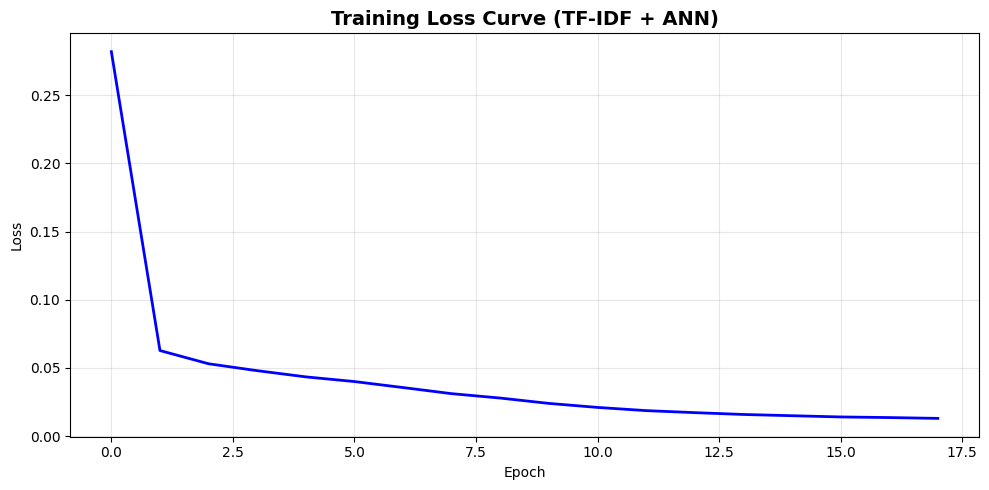


[HASIL 5.2] Prediksi pada Data Test selesai.


In [ ]:
# ==========================================================
# TAHAP 5: TRAINING MODEL ANN DENGAN TF-IDF
# ==========================================================
from sklearn.neural_network import MLPClassifier

print("\n[HASIL 5.1] Memulai Training Model ANN dengan TF-IDF Features...")

# Inisialisasi Model dengan Regularisasi
ann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 hidden layers (lebih dalam untuk TF-IDF)
    activation='relu',
    solver='adam',
    max_iter=100,                  # Max epoch
    learning_rate_init=0.001,      # Learning rate
    alpha=0.0001,                  # Regularisasi L2
    early_stopping=True,           # Stop jika tidak ada improvement
    validation_fraction=0.1,       # 10% data training untuk validasi
    random_state=42,
    verbose=False
)

print(f"   [INFO] Arsitektur: Input({X_train.shape[1]}) -> 128 -> 64 -> Output(3)")
print(f"   [INFO] Max Epoch: {ann_model.max_iter}")
print(f"   [INFO] Early Stopping: Aktif")
print("\n   [⏳] Training dimulai...")

# Training
ann_model.fit(X_train, Y_train)

# Informasi Training
final_loss = ann_model.loss_curve_[-1]
final_epoch = len(ann_model.loss_curve_)

print(f"\n   [✓] Training selesai!")
print(f"   [✓] Loss terakhir: {final_loss:.6f}")
print(f"   [✓] Berhenti pada epoch ke-{final_epoch}")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(ann_model.loss_curve_, linewidth=2, color='blue')
plt.title('Training Loss Curve (TF-IDF + ANN)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediksi
Y_pred = ann_model.predict(X_test)

print("\n[HASIL 5.2] Prediksi pada Data Test selesai.")


EVALUASI MODEL TF-IDF + ANN

[HASIL 6.1] AKURASI GLOBAL: 0.9861 (98.61%)


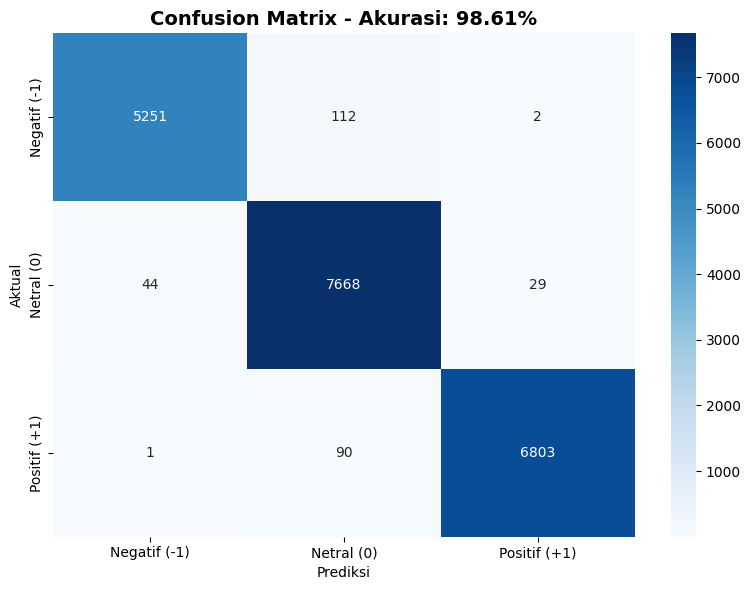


[HASIL 6.2] Laporan Klasifikasi Detail:
              precision  recall  f1-score     support
Negatif (-1)     0.9915  0.9788    0.9851   5365.0000
Netral (0)       0.9743  0.9906    0.9824   7741.0000
Positif (+1)     0.9955  0.9868    0.9911   6894.0000
accuracy         0.9861  0.9861    0.9861      0.9861
macro avg        0.9871  0.9854    0.9862  20000.0000
weighted avg     0.9862  0.9861    0.9861  20000.0000

[HASIL 6.3] Analisis Detail per Kelas:
------------------------------------------------------------

Negatif (-1):
  - Precision: 0.9915 (99.15%)
  - Recall:    0.9788 (97.88%)
  - F1-Score:  0.9851
  - Support:   5365 samples

Netral (0):
  - Precision: 0.9743 (97.43%)
  - Recall:    0.9906 (99.06%)
  - F1-Score:  0.9824
  - Support:   7741 samples

Positif (+1):
  - Precision: 0.9955 (99.55%)
  - Recall:    0.9868 (98.68%)
  - F1-Score:  0.9911
  - Support:   6894 samples

[HASIL 6.4] Membuat Word Cloud...


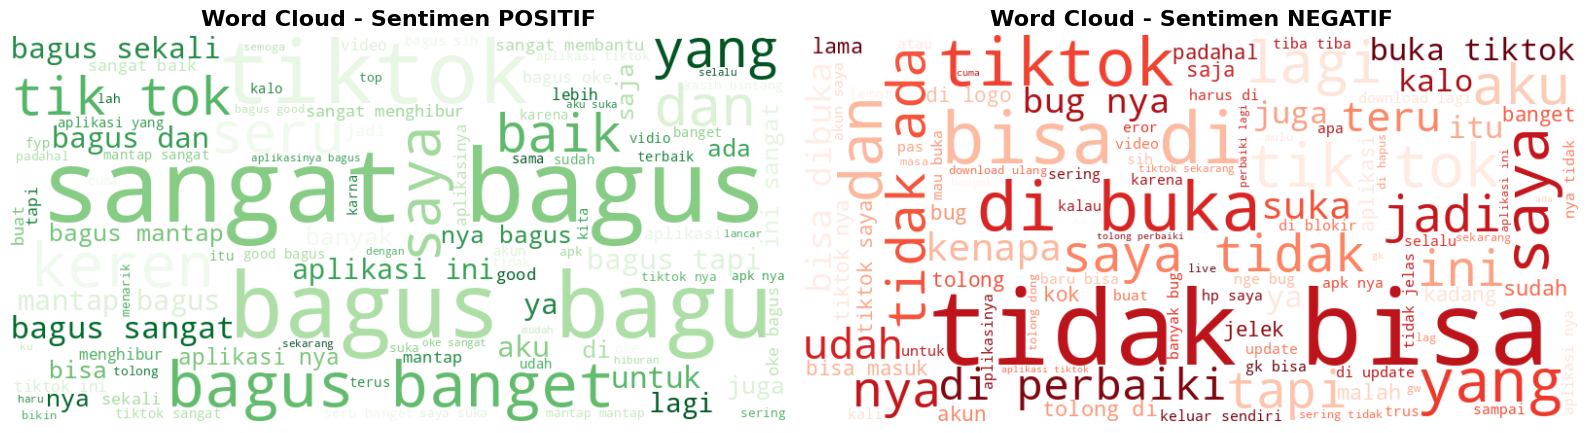


[HASIL 6.5] Top 10 Kata Terbanyak per Sentimen:
------------------------------------------------------------

POSITIF:
  bagus                : 3401x
  sangat               : 1355x
  tiktok               :  881x
  mantap               :  743x
  dan                  :  726x
  nya                  :  631x
  aplikasi             :  600x
  banget               :  577x
  oke                  :  545x
  bisa                 :  532x

NEGATIF:
  tidak                : 3980x
  di                   : 3251x
  tiktok               : 2820x
  bisa                 : 2707x
  saya                 : 1906x
  nya                  : 1679x
  buka                 : 1305x
  bug                  : 1239x
  lagi                 : 1154x
  ini                  : 1053x

KESIMPULAN EVALUASI

✓ Akurasi Global:     98.61%
✓ F1-Score (Macro):   0.9862
✓ F1-Score (Weighted): 0.9861
✓ Total Data Test:    20000 samples
✓ Prediksi Benar:     19722 samples
✓ Prediksi Salah:     278 samples

EVALUASI TF-IDF + ANN SELESAI


In [ ]:
# ==========================================================
# TAHAP 6: EVALUASI MODEL (TF-IDF VERSION)
# ==========================================================
!pip install wordcloud
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from collections import Counter

print("\n" + "="*60)
print("EVALUASI MODEL TF-IDF + ANN")
print("="*60)

# A. Hitung Akurasi
accuracy_global = accuracy_score(Y_test, Y_pred)

print(f"\n[HASIL 6.1] AKURASI GLOBAL: {accuracy_global:.4f} ({accuracy_global*100:.2f}%)")

# B. Confusion Matrix
class_labels = [-1, 0, 1]
display_labels = ['Negatif (-1)', 'Netral (0)', 'Positif (+1)']

cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=display_labels,
            yticklabels=display_labels)
plt.title(f'Confusion Matrix - Akurasi: {accuracy_global*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.show()

# C. Classification Report
report = classification_report(
    Y_test, Y_pred,
    labels=class_labels,
    target_names=display_labels,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()

print("\n[HASIL 6.2] Laporan Klasifikasi Detail:")
print(report_df.round(4))

# D. Analisis per Kelas
print("\n[HASIL 6.3] Analisis Detail per Kelas:")
print("-" * 60)

for class_val, class_name in zip(class_labels, display_labels):
    precision = report_df.loc[class_name, 'precision']
    recall = report_df.loc[class_name, 'recall']
    f1 = report_df.loc[class_name, 'f1-score']
    support = int(report_df.loc[class_name, 'support'])

    print(f"\n{class_name}:")
    print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  - F1-Score:  {f1:.4f}")
    print(f"  - Support:   {support} samples")

# E. Word Cloud untuk Positif dan Negatif
print("\n[HASIL 6.4] Membuat Word Cloud...")

# Gabungkan prediksi dengan teks
df_test = df.loc[X_test_raw.index].copy()
df_test['predicted_sentiment'] = Y_pred

# Pisahkan teks berdasarkan prediksi
text_positif = ' '.join(df_test[df_test['predicted_sentiment'] == 1]['cleaned_text'].values)
text_negatif = ' '.join(df_test[df_test['predicted_sentiment'] == -1]['cleaned_text'].values)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word Cloud Positif
if len(text_positif) > 0:
    wc_pos = WordCloud(width=800, height=400, background_color='white',
                       colormap='Greens', max_words=100).generate(text_positif)
    axes[0].imshow(wc_pos, interpolation='bilinear')
    axes[0].set_title('Word Cloud - Sentimen POSITIF', fontsize=16, fontweight='bold')
    axes[0].axis('off')

# Word Cloud Negatif
if len(text_negatif) > 0:
    wc_neg = WordCloud(width=800, height=400, background_color='white',
                       colormap='Reds', max_words=100).generate(text_negatif)
    axes[1].imshow(wc_neg, interpolation='bilinear')
    axes[1].set_title('Word Cloud - Sentimen NEGATIF', fontsize=16, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# F. Top Kata per Sentimen
print("\n[HASIL 6.5] Top 10 Kata Terbanyak per Sentimen:")
print("-" * 60)

if len(text_positif) > 0:
    top_pos = Counter(text_positif.split()).most_common(10)
    print("\nPOSITIF:")
    for word, count in top_pos:
        print(f"  {word:20s} : {count:4d}x")

if len(text_negatif) > 0:
    top_neg = Counter(text_negatif.split()).most_common(10)
    print("\nNEGATIF:")
    for word, count in top_neg:
        print(f"  {word:20s} : {count:4d}x")

# G. Kesimpulan
print("\n" + "="*60)
print("KESIMPULAN EVALUASI")
print("="*60)

f1_macro = report_df.loc['macro avg', 'f1-score']
f1_weighted = report_df.loc['weighted avg', 'f1-score']

print(f"\n✓ Akurasi Global:     {accuracy_global*100:.2f}%")
print(f"✓ F1-Score (Macro):   {f1_macro:.4f}")
print(f"✓ F1-Score (Weighted): {f1_weighted:.4f}")
print(f"✓ Total Data Test:    {len(Y_test)} samples")
print(f"✓ Prediksi Benar:     {(Y_test == Y_pred).sum()} samples")
print(f"✓ Prediksi Salah:     {(Y_test != Y_pred).sum()} samples")

print("\n" + "="*60)
print("EVALUASI TF-IDF + ANN SELESAI")
print("="*60)

In [ ]:
# ==========================================================
# TAHAP 7: INTERFACE PREDIKSI INTERAKTIF (INPUT MANUAL)
# ==========================================================
import ipywidgets as widgets
from IPython.display import display, HTML
import re

print("\n[HASIL 7.1] Menyiapkan Interface Prediksi Interaktif...")

# --- 1. FUNGSI PRA-PEMROSESAN (SAMA DENGAN TRAINING) ---
def preprocess_single_text(text):
    """Fungsi preprocessing yang sama dengan data training."""
    # Normalisasi slang (gunakan kamus yang sama)
    slang_dict = {
        'gak': 'tidak', 'ga': 'tidak', 'gmn': 'bagaimana', 'bgus': 'bagus',
        'brg': 'barang', 'dgn': 'dengan', 'sdh': 'sudah', 'yg': 'yang',
        'udh': 'sudah', 'tpi': 'tapi', 'sy': 'saya', 'krg': 'kurang',
        'pky': 'pakai', 'mksh': 'terima kasih', 'thx': 'terima kasih',
        'tp': 'tapi', 'utk': 'untuk', 'aja': 'saja', 'bgt': 'banget',
        'ok': 'oke', 'mantab': 'mantap', 'bwt': 'buat', 'cepet': 'cepat',
        'respon': 'respons', 'tdk': 'tidak', 'jg': 'juga', 'sampe': 'sampai'
    }

    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Normalisasi slang
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    text = " ".join(normalized_words)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- 2. FUNGSI PREDIKSI ---
def predict_sentiment(button):
    """Fungsi yang dipanggil saat tombol diklik."""

    input_text = text_input.value

    if not input_text.strip():
        output_label.value = "<div style='color: red; font-weight: bold;'>❌ Error: Harap masukkan teks ulasan.</div>"
        output_clean.value = ""
        return

    # 1. Pra-pemrosesan
    teks_bersih = preprocess_single_text(input_text)

    # 2. Validasi variabel
    try:
        # Cek apakah model dan vectorizer sudah ada
        if 'tfidf' not in globals() or 'ann_model' not in globals():
            output_label.value = "<div style='color: red; font-weight: bold;'>❌ Error: Model belum dilatih. Jalankan Tahap 4-5 terlebih dahulu!</div>"
            return

        # 3. Vektorisasi dengan TF-IDF
        X_new = tfidf.transform([teks_bersih])

        # 4. Prediksi
        prediksi_sentimen = ann_model.predict(X_new)[0]

        # 5. Prediksi probabilitas (jika tersedia)
        try:
            proba = ann_model.predict_proba(X_new)[0]
            proba_negatif = proba[0] * 100  # Kelas -1
            proba_netral = proba[1] * 100    # Kelas 0
            proba_positif = proba[2] * 100   # Kelas 1
            show_proba = True
        except:
            show_proba = False

        # 6. Format hasil
        sentiment_map = {
            1: ("Positif", "✅", "green"),
            0: ("Netral", "😐", "orange"),
            -1: ("Negatif", "❌", "red")
        }

        label, icon, color = sentiment_map.get(prediksi_sentimen, ("Tidak Terdefinisi", "❓", "black"))

        # 7. Tampilkan hasil dengan styling
        result_html = f"""
        <div style='border: 3px solid {color}; padding: 20px; border-radius: 10px; background-color: #f9f9f9; margin-top: 10px;'>
            <h3 style='color: {color}; margin: 0;'>
                {icon} Hasil Prediksi: <strong>{label} ({prediksi_sentimen:+d})</strong>
            </h3>
        """

        if show_proba:
            result_html += f"""
            <div style='margin-top: 15px;'>
                <p style='margin: 5px 0;'><strong>Tingkat Keyakinan Model:</strong></p>
                <div style='background: linear-gradient(to right, red {proba_negatif}%, orange {proba_negatif}%, orange {proba_negatif + proba_netral}%, green {proba_negatif + proba_netral}%);
                            height: 30px; border-radius: 5px; position: relative;'>
                </div>
                <div style='display: flex; justify-content: space-between; margin-top: 5px; font-size: 12px;'>
                    <span>Negatif: {proba_negatif:.1f}%</span>
                    <span>Netral: {proba_netral:.1f}%</span>
                    <span>Positif: {proba_positif:.1f}%</span>
                </div>
            </div>
            """

        result_html += "</div>"

        output_label.value = result_html
        output_clean.value = f"<p style='font-size: 12px; color: black; margin-top: 10px;'><em>Teks setelah preprocessing:</em> {teks_bersih}</p>"

    except Exception as e:
        output_label.value = f"<div style='color: red; font-weight: bold;'>❌ Terjadi kesalahan: {str(e)}</div>"
        output_clean.value = ""

# --- 3. PEMBUATAN WIDGET ---

# Header
display(HTML("""
<div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px; border-radius: 10px; margin-bottom: 20px;'>
    <h2 style='color: white; margin: 0; text-align: center;'>
        🤖 Uji Coba Model ANN - Analisis Sentimen TF-IDF
    </h2>
    <p style='color: white; text-align: center; margin: 5px 0 0 0;'>
        Masukkan ulasan untuk memprediksi sentimen: Positif, Netral, atau Negatif
    </p>
</div>
"""))

# Input Teks
text_input = widgets.Textarea(
    value='Aplikasi TikTok sangat bagus dan menghibur!',
    placeholder='Ketik ulasan Anda di sini...',
    description='📝 Ulasan:',
    disabled=False,
    layout=widgets.Layout(height='120px', width='100%'),
    style={'description_width': '80px'}
)

# Tombol Prediksi
predict_button = widgets.Button(
    description='🔍 Prediksi Sentimen',
    disabled=False,
    button_style='success',
    tooltip='Klik untuk menjalankan prediksi',
    icon='check',
    layout=widgets.Layout(width='200px', height='40px')
)

# Area Output
output_label = widgets.HTML(
    value="<p style='text-align: center; color: black;'>👆 Klik tombol 'Prediksi Sentimen' untuk melihat hasil</p>",
    layout=widgets.Layout(margin='15px 0 0 0')
)

output_clean = widgets.HTML(value="")

# --- 4. HUBUNGKAN EVENT ---
predict_button.on_click(predict_sentiment)

# --- 5. TAMPILKAN WIDGET ---
display(widgets.VBox([
    text_input,
    widgets.HBox([predict_button], layout=widgets.Layout(justify_content='center')),
    output_label,
    output_clean
], layout=widgets.Layout(padding='10px')))



print("\n[✓] Interface prediksi interaktif berhasil dibuat!")
print("    Scroll ke bawah untuk mencoba prediksi manual.")


[HASIL 7.1] Menyiapkan Interface Prediksi Interaktif...



[✓] Interface prediksi interaktif berhasil dibuat!
    Scroll ke bawah untuk mencoba prediksi manual.
